# NLP Disaster Tweets Project

In this project we will utilize word embeddings to classify tweets acording to their relationship to natural disasters. This process can be incredibly difficult to perform due to the nature of tweets. For example, while the word `"ablaze"` may sound like it is referring to a fire, an example tweet of `"On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE"` when referring to a beautiful sunset. This distinction is extremely important and is the target of this classification. Can we seperate tweets that contain words that sound like a natural disaster based off if it was actually referring to a natural disaster? In this project, we will proceed to train a model to classify tweets on whether they are related to a natural disaster or not. 

We will proceed through the following Phases:

1. Exploratory Data Analysis
2. Text Cleaning
3. Model Building
4. Evaluation
5. Conclusion

In [2]:
import numpy as np
import pandas as pd
import os

import nltk
import spacy
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

from transformers import DistilBertTokenizer, TFDistilBertModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
### make sure tensorflow is using GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ' , len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [4]:
train_data = pd.read_csv(os.path.join(r'C:\Users\Ryan\Files\DTSA 5511\NLP Project', 'train.csv'))
print("Train Data")
display(train_data.head())

test_data = pd.read_csv(os.path.join(r'C:\Users\Ryan\Files\DTSA 5511\NLP Project', 'test.csv'))
print("Test Data")
display(test_data.head())

Train Data


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Test Data


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Exploratory Data Analysis (EDA)

Let's start by checking the shape and basic information of the data. We see that our train and test dataset contains a total of about 10,900 rows. The key thing to note is that only id, text, and target have no null rows. It appears that keyword is filled in most of the dataset with location missing from around 1/3rd of all rows. Let's plan on dropping location and looking further into keywords.

In [5]:
print(f'Train Shape: {train_data.shape}')
print(f'Test Shape: {test_data.shape}')

Train Shape: (7613, 5)
Test Shape: (3263, 4)


In [6]:
display(train_data.info())
display(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


None

### Target Distribution

Before looking at Keyword, lets start by looking at Target distribution. We see that for the train data set, 4300 of the 7600 records are showing a value of 0 or No disaster, while 3200 of them are showing a value of 1 or Disaster. There is a slight lean towards no disaster in the records.

target
0    4342
1    3271
Name: count, dtype: int64

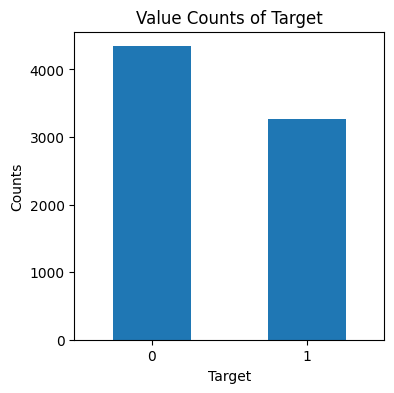

In [7]:
value_counts = train_data['target'].value_counts()
display(value_counts)

# Plotting the bar chart
plt.figure(figsize=(4, 4))
value_counts.plot(kind='bar')
plt.title('Value Counts of Target')
plt.xlabel('Target')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

### Keyword Analysis
From here on we will focus on train_data alone as test_data appears to have similar issues to train_data in terms of missing values and is from the same source. this means any analysis we ahve from test will likely follow the same patterns.

Based off the finding of above, lets start by looking at the keywords column. The keywords column has %20 instead of a space so let's start by cleaning that up along with finding the top 50 words in keywords.

In [8]:
train_data['keyword'] =train_data['keyword'].str.replace('%20', ' ')
keywords = train_data['keyword'].value_counts()
print(keywords)

top_keywords = keywords.head(50).index

keyword
fatalities             45
deluge                 42
armageddon             42
sinking                41
damage                 41
                       ..
forest fire            19
epicentre              12
threat                 11
inundation             10
radiation emergency     9
Name: count, Length: 221, dtype: int64


### Keyword Distribution
Next let's look at the distribution of these words for the top 50 words. All of the top 50 words appear around 40 times which indicates keywords are fairly evenly distributed. However, when looking at the target split, some words are far more likely to have a relation to natural disaters indicating that people don't tend to use these words in a context outside of natural disasters. Examples of this include `wreckage`, `oil spill`, and `typhoon`. On the flip side, words like `armageddon` and `blizzard` tend to rarely reference natural disasters likely referring to movies or a well known gaming company when being used.

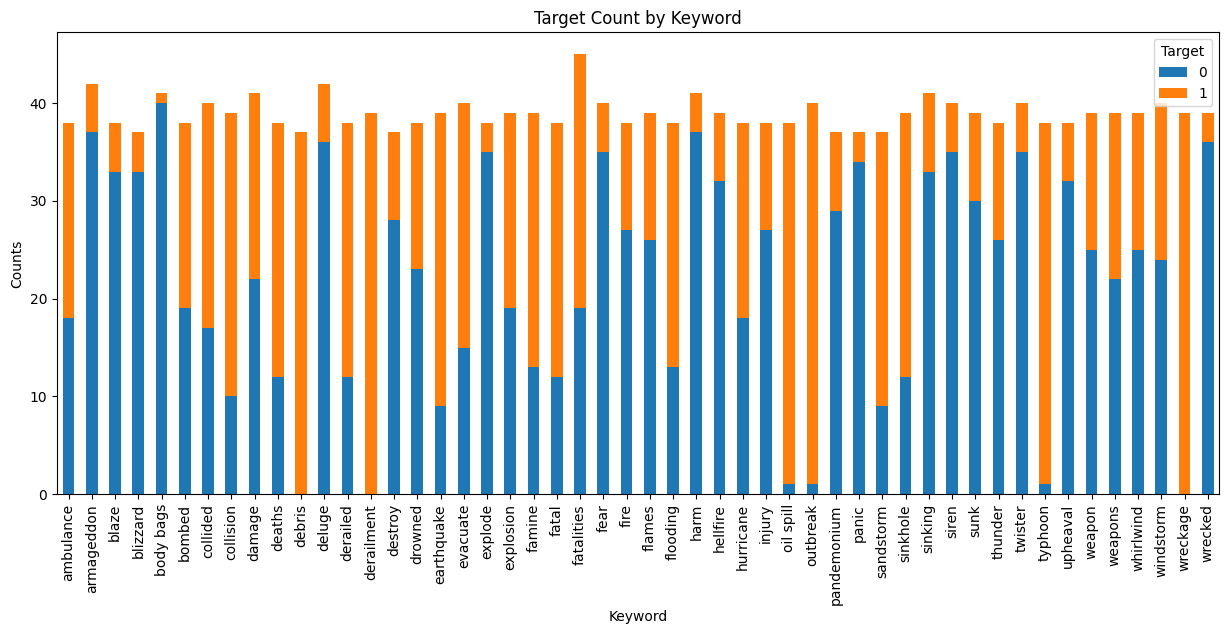

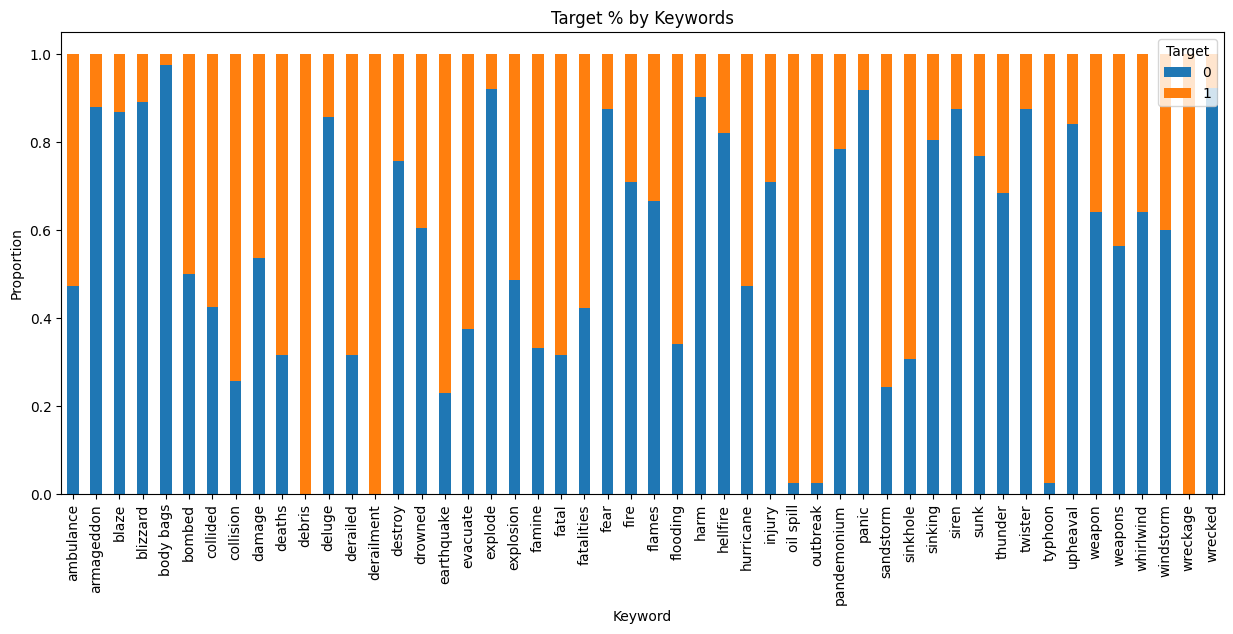

In [9]:
filtered_data = train_data[train_data['keyword'].isin(top_keywords)]

filtered_data.groupby('keyword')['target'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(15, 6))
plt.title('Target Count by Keyword')
plt.xlabel('Keyword')
plt.ylabel('Counts')
plt.legend(title='Target', loc='upper right')
plt.show()

filtered_data.groupby('keyword')['target'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, figsize=(15, 6))
plt.title('Target % by Keywords')
plt.xlabel('Keyword')
plt.ylabel('Proportion')
plt.legend(title='Target', loc='upper right')
plt.show()

### Confirming Keyword is in Text
Now let's confirm if keyword is in text. If it is always in text, there is no need to keep the column. We find that most of the rows are in Text, with 913 missing of which 852 had keywords. While keyword may have some benefit, for some of these rows the keyword may not be all that related. As such, I think we can safely remove this column and focus on text. 

Keyword in Text Counts


keyword_in_text
True     6700
False     913
Name: count, dtype: int64

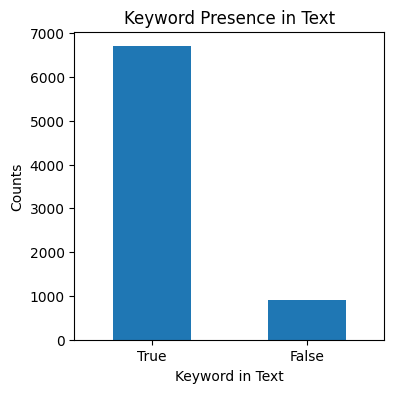

In [10]:
train_data['keyword_in_text'] = train_data.apply(lambda row: str(row['keyword']).lower() in str(row['text']).lower() if pd.notna(row['keyword']) else False, axis=1)
keyword_in_text_counts = train_data['keyword_in_text'].value_counts()
print("Keyword in Text Counts")
display(keyword_in_text_counts)

plt.figure(figsize=(4, 4))
keyword_in_text_counts.plot(kind='bar')
plt.title('Keyword Presence in Text')
plt.xlabel('Keyword in Text')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

In [11]:
pd.set_option('display.max_colwidth', None)
train_data[(train_data['keyword_in_text'] == False) & (pd.notnull(train_data['keyword']))]

,id,keyword,location,text,target,keyword_in_text
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw,0,False
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0,False
45,65,ablaze,NaN,I gained 3 followers in the last week. You? Know your stats and grow with http://t.co/TIyUliF5c6,0,False
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0,False
49,71,ablaze,England.,First night with retainers in. It's quite weird. Better get used to it; I have to wear them every single night for the next year at least.,0,False
...,...,...,...,...,...,...
7402,10590,wounded,United States,Gunmen open fire on bus near El Salvador's capital killing 4 a week after gang attacks killed 8 bus drivers: http://t.co/Pz56zJSsfT bitÛ_,1,False
7422,10616,wounded,"Washington, D.C.",The Police Chief assured the crowd that this officer-related shooting would be investigated: http://t.co/KMXzhO5TFM. http://t.co/AlBvDNwJtg,1,False
7428,10626,wounded,"Fredericksburg, Virginia",.@wwp is serving more than 75k veterans. 52k OIF/OEF vets have physical wounds; many more have invisible ones http://t.co/sHHLV4dPlz #client,1,False
7440,10647,wounds,Kashmir!,Acc to the study conducted by SKIMS morethan 50% population in #Kashmir suffer psychiatric disorders http://t.co/sAF9MoSkSN #KashmirConflict,1,False


### Text Analysis

Let's start by analyzing the text column before cleaning it. We will check text length and word counts. Text lenght has a long tail to the left with the peak around 140 characters. The word length however is normally distributed with the bulk falling between 10 and 20 words. This may reflect alot of the articles that had links in them potentially.

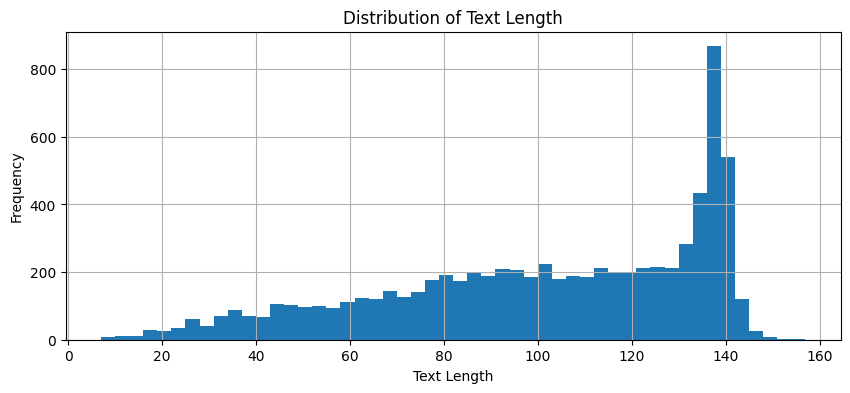

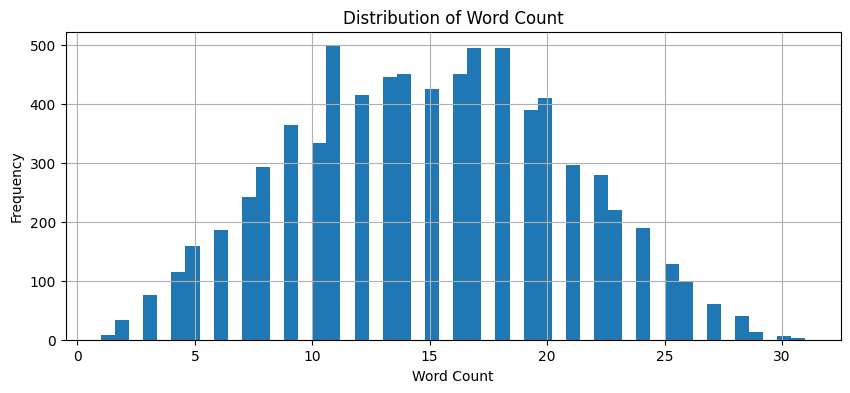

In [12]:
# EDA on the text field
train_data['text_length'] = train_data['text'].apply(len)
train_data['word_count'] = train_data['text'].apply(lambda x: len(x.split()))

# Distribution of text length
plt.figure(figsize=(10, 4))
train_data['text_length'].hist(bins=50)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Distribution of word count
plt.figure(figsize=(10, 4))
train_data['word_count'].hist(bins=50)
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

### Text Cleaning
We will now perform text cleaning. This code was adapted from the article below by MonkeyLearn. In this text cleaning we will perform the following utilizing NLTK and Spacy:
 - Text Normalization with lower casing all words
 - Stop word removal
 - Lemmatization using Spacy to augment NLTK.

Roldos, I. (2021, May 31). Text cleaning for NLP: A tutorial. MonkeyLearn Blog. https://monkeylearn.com/blog/text-cleaning/ 

When checking a sample of the cleaned text we can clearly see that the filler words were removed and the text looks overall cleaner. It also shortened the words to their roots to better enable us to classify. 

In [13]:
nlp = spacy.load('en_core_web_sm')

def clean_text(text):
    text = text.lower()
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalnum() and word not in stop_words]
    doc = nlp(' '.join(words))
    words = [token.lemma_ for token in doc]
    return ' '.join(words)

In [14]:
# Apply text cleaning to the 'text' column
train_data['cleaned_text'] = train_data['text'].apply(clean_text)

print("Cleaned Text")
display(train_data[['text', 'cleaned_text']].head())

Cleaned Text


,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,deed reason earthquake may allah forgive we
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,resident ask place notify officer evacuation shelter place order expect
3,"13,000 people receive #wildfires evacuation orders in California",people receive wildfire evacuation order california
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,get send photo ruby alaska smoke wildfire pour school


Now that the text is cleaned, lets recheck the text length and word count distributions. Both of these distributions are now following a normal distribution with most of the texts being between 20 and 100 characters. This looks to be moving in the right direction.

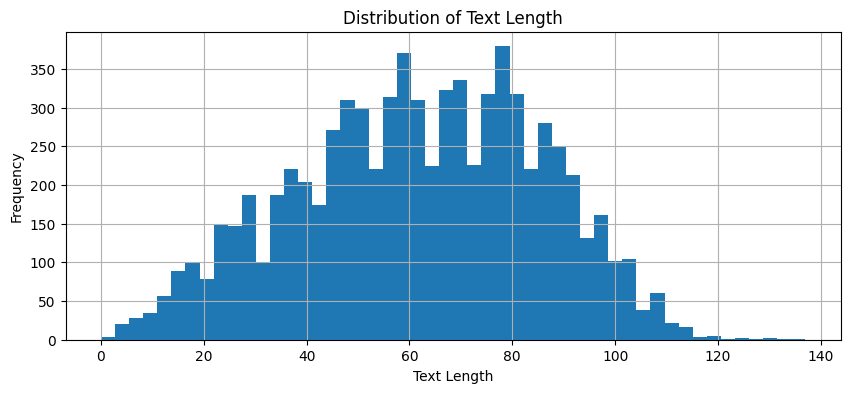

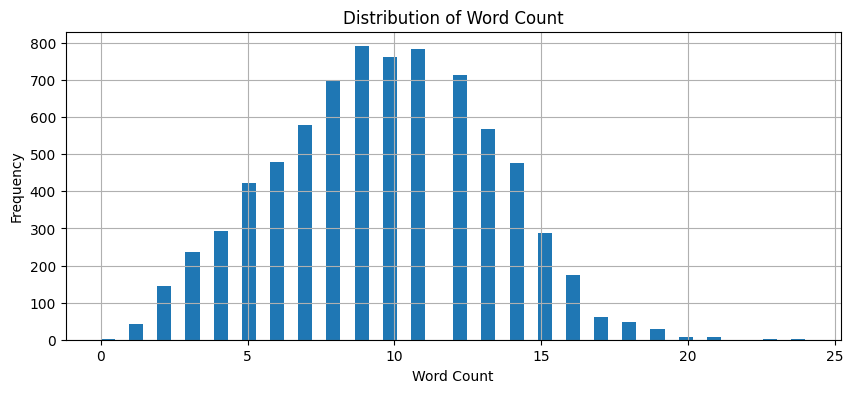

In [15]:
# EDA on the text field
train_data['text_length_cleaned'] = train_data['cleaned_text'].apply(len)
train_data['word_count_cleaned'] = train_data['cleaned_text'].apply(lambda x: len(x.split()))

# Distribution of text length
plt.figure(figsize=(10, 4))
train_data['text_length_cleaned'].hist(bins=50)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Distribution of word count
plt.figure(figsize=(10, 4))
train_data['word_count_cleaned'].hist(bins=50)
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

### Text vs Cleaned Text Comparison

Upon checking the most common words, we can ee that the top words are basically all filler words in text. In cleaned text they tend to be words that may have a larger impact like `kill` or `burn`. There are still some words that may need to removed but it is overall alot better. We also are manually adjusting the text cleaning code above to additionally remove http and https. 

In [16]:
def get_most_common_words(text_series, num_words=30):
    all_words = ' '.join(text_series).split()
    word_counts = Counter(all_words)
    common_words = word_counts.most_common(num_words)
    return common_words

most_common_words_text = get_most_common_words(train_data['text'])
print("Most Common Words in Original Text:")
print(most_common_words_text)

most_common_words_cleaned_text = get_most_common_words(train_data['cleaned_text'])
print("Most Common Words in Cleaned Text:")
print(most_common_words_cleaned_text)

Most Common Words in Original Text:
[('the', 2575), ('a', 1845), ('to', 1805), ('in', 1757), ('of', 1722), ('and', 1302), ('I', 1197), ('for', 820), ('is', 814), ('on', 773), ('-', 763), ('you', 632), ('The', 552), ('my', 549), ('with', 508), ('that', 492), ('at', 485), ('by', 469), ('it', 433), ('from', 372), ('be', 371), ('was', 363), ('have', 353), ('are', 345), ('this', 335), ('like', 318), ('&amp;', 295), ('A', 290), ('as', 282), ('just', 258)]
Most Common Words in Cleaned Text:
[('http', 4376), ('get', 426), ('like', 393), ('fire', 355), ('amp', 344), ('https', 340), ('go', 296), ('new', 229), ('via', 218), ('one', 204), ('say', 200), ('people', 198), ('news', 198), ('see', 185), ('video', 174), ('kill', 171), ('make', 170), ('burn', 166), ('2', 165), ('crash', 160), ('bomb', 158), ('disaster', 157), ('come', 157), ('emergency', 156), ('attack', 153), ('body', 149), ('year', 147), ('would', 143), ('look', 142), ('police', 140)]


In [17]:
train_data[train_data['cleaned_text'].str.contains('http')]

,id,keyword,location,text,target,keyword_in_text,text_length,word_count,cleaned_text,text_length_cleaned,word_count_cleaned
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1,True,55,5,bbcmtd wholesale market ablaze http,35,5
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw,0,False,67,10,always try bring heavy metal rt http,36,7
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi,1,True,82,9,africanbaze break news nigeria flag set ablaze aba http,55,9
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N,0,True,76,13,plus side look sky last night ablaze http,41,8
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA,1,True,55,8,inec office abia set ablaze http,32,6
...,...,...,...,...,...,...,...,...,...,...,...
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site mosque - Reuters via World - Google News - Wall ... http://t.co/nF4IculOje,1,False,121,20,suicide bomber kill 15 saudi security site mosque reuter via world google news wall http,88,15
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Reno Oklahoma Tornado Nearly Runs Over ... - http://t.co/3SICroAaNz http://t.co/I27Oa0HISp,1,False,134,16,stormchase violent record breaking el reno oklahoma tornado nearly run http http,80,12
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,False,83,11,two giant crane hold bridge collapse nearby home http,53,9
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,False,65,8,utc 5 km volcano hawaii http,28,6


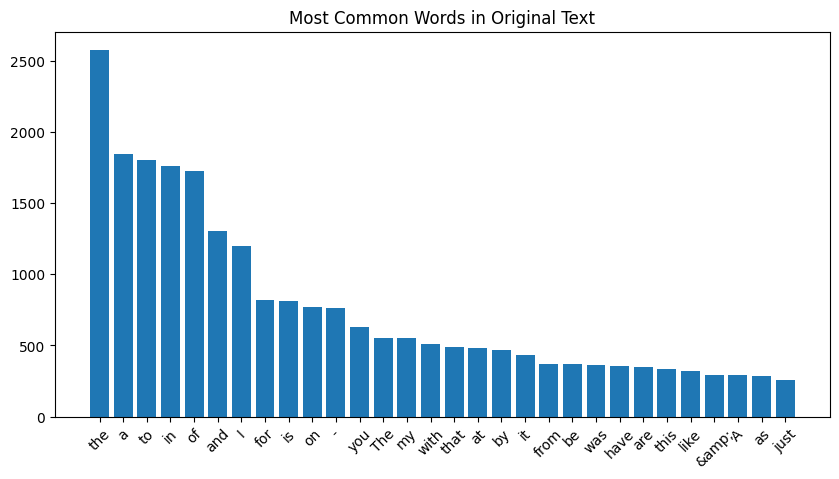

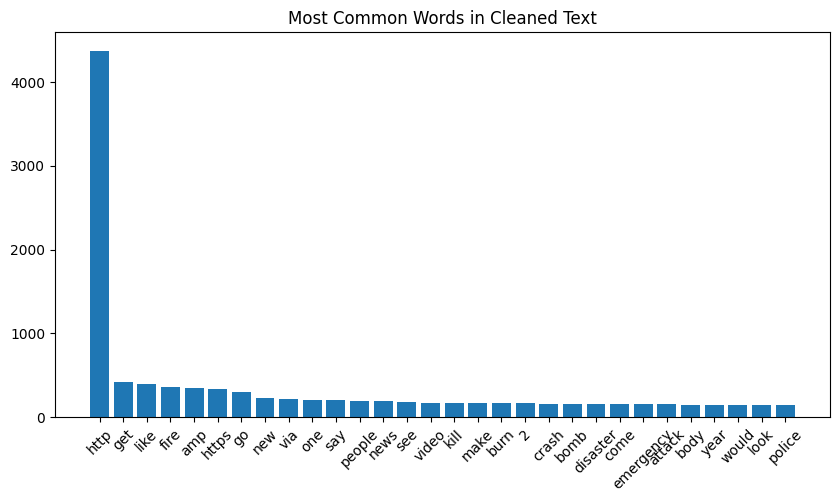

In [18]:
def plot_common_words(common_words, title):
    words, counts = zip(*common_words)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_common_words(most_common_words_text, 'Most Common Words in Original Text')
plot_common_words(most_common_words_cleaned_text, 'Most Common Words in Cleaned Text')

### Model Building

Now let's prepare to run the model. We will reload data to ensure anything we did before is reset and reclean the data with clean_text. For the final model, we will only use the `text` column in the classification. Once again we will reload our train data set and process it with the final clean_Text alogorithm we had. We will ten split it in to a train and validation dataset. 

In [19]:
nlp = spacy.load('en_core_web_sm')

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|https\S+', '', text)
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalnum() and word not in stop_words]
    doc = nlp(' '.join(words))
    words = [token.lemma_ for token in doc]
    return ' '.join(words)

In [20]:
train_data = pd.read_csv(os.path.join(r'C:\Users\Ryan\Files\DTSA 5511\NLP Project', 'train.csv'))
print("Train Data")
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
display(train_data.head())

# Prepare data for Modeling
X = train_data['cleaned_text']
y = train_data['target']

Train Data


,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deed reason earthquake may allah forgive we
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,resident ask place notify officer evacuation shelter place order expect
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,people receive wildfire evacuation order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,get send photo ruby alaska smoke wildfire pour school


In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=37)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

In [22]:
embedding = "https://www.kaggle.com/models/google/nnlm/TensorFlow2/en-dim50/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

In [23]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 32)                1632      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 48,193,321
Trainable params: 48,193,321
No

In [24]:
initial_lr = 0.0005
model.compile(optimizer=Adam(learning_rate=initial_lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping, reduce_lr])

Epoch 1/20
191/191 [==============================] - 4s 17ms/step - loss: 1.6357 - accuracy: 0.5639 - val_loss: 1.2282 - val_accuracy: 0.5758 - lr: 5.0000e-04
Epoch 2/20
191/191 [==============================] - 3s 16ms/step - loss: 1.0107 - accuracy: 0.6225 - val_loss: 0.8309 - val_accuracy: 0.7236 - lr: 5.0000e-04
Epoch 3/20
191/191 [==============================] - 3s 16ms/step - loss: 0.7244 - accuracy: 0.7604 - val_loss: 0.6357 - val_accuracy: 0.7991 - lr: 5.0000e-04
Epoch 4/20
191/191 [==============================] - 3s 16ms/step - loss: 0.5682 - accuracy: 0.8255 - val_loss: 0.5573 - val_accuracy: 0.7984 - lr: 5.0000e-04
Epoch 5/20
191/191 [==============================] - 3s 17ms/step - loss: 0.4725 - accuracy: 0.8601 - val_loss: 0.5370 - val_accuracy: 0.8024 - lr: 5.0000e-04
Epoch 6/20
191/191 [==============================] - 3s 17ms/step - loss: 0.4091 - accuracy: 0.8911 - val_loss: 0.5371 - val_accuracy: 0.7971 - lr: 5.0000e-04
Epoch 7/20
191/191 [====================

##### Evaluation
This model is performing decently at around 83% F1 for Not disaster and 77% for disaster. As our baseline model with early stopping and reduce LR on plateaus it is performing reasonably well, however further improvements can be made.

48/48 [==============================] - 0s 2ms/step
[[720 157]
 [144 502]]


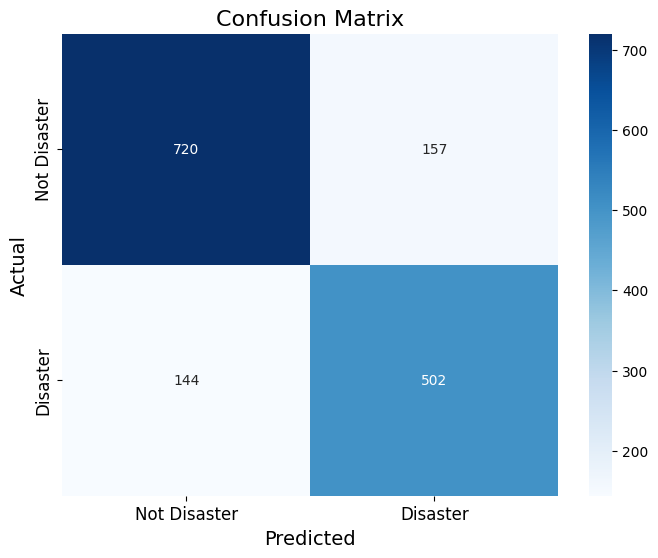

              precision    recall  f1-score   support

Not Disaster       0.83      0.82      0.83       877
    Disaster       0.76      0.78      0.77       646

    accuracy                           0.80      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.80      0.80      0.80      1523



In [25]:
val_predictions = model.predict(val_dataset)
val_predictions = (val_predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Disaster', 'Disaster'], yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_val, val_predictions, target_names=['Not Disaster', 'Disaster']))

### Optimization
- Batch size
    - Adjusted batch size to 8 and 16 from 32. 16 performed the best
- Learning Rate modifications
    - Tested with different learning rate initializations.
    - Switched to a Learning rate scheduler to help the model fine tune more
- Dense Filter Combinations
    - testing out different Dense filter combinations of 16, 32, 64. 32 filters on both perform the best.
    - L2 regularization of .2 seems to perform the best. higher and the model trains to slow. Lower and it trains to fast and ends early.
- Optimizers
    - Tested out RMSprop. Adam performs better based off my testing
 
After testing the above optimizations, we have landed on this as our final model using Google's en-dim50 embeddings model

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=37)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16)

embedding = "https://www.kaggle.com/models/google/nnlm/TensorFlow2/en-dim50/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

In [28]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_3 (Dense)             (None, 32)                1632      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,192,777
Trainable params: 48,192,777


In [29]:
initial_lr = 0.0005
model.compile(optimizer=Adam(learning_rate=initial_lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

def exponential_decay(epoch, lr = initial_lr):
    initial_lr = lr
    k = 0.1
    return initial_lr * tf.math.exp(-k * epoch)

lr_scheduler = LearningRateScheduler(exponential_decay)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
381/381 [==============================] - 7s 17ms/step - loss: 1.2670 - accuracy: 0.6020 - val_loss: 0.8672 - val_accuracy: 0.7163 - lr: 5.0000e-04
Epoch 2/20
381/381 [==============================] - 6s 17ms/step - loss: 0.7364 - accuracy: 0.7163 - val_loss: 0.6313 - val_accuracy: 0.7846 - lr: 4.5242e-04
Epoch 3/20
381/381 [==============================] - 6s 17ms/step - loss: 0.5839 - accuracy: 0.7957 - val_loss: 0.5620 - val_accuracy: 0.7919 - lr: 3.7041e-04
Epoch 4/20
381/381 [==============================] - 6s 16ms/step - loss: 0.5095 - accuracy: 0.8435 - val_loss: 0.5388 - val_accuracy: 0.8037 - lr: 2.7441e-04
Epoch 5/20
381/381 [==============================] - 6s 16ms/step - loss: 0.4633 - accuracy: 0.8665 - val_loss: 0.5312 - val_accuracy: 0.8017 - lr: 1.8394e-04
Epoch 6/20
381/381 [==============================] - 6s 17ms/step - loss: 0.4385 - accuracy: 0.8778 - val_loss: 0.5288 - val_accuracy: 0.8056 - lr: 1.1157e-04
Epoch 7/20
381/381 [====================

#### Evaluation
With these optimizations, we have slightly improved our F1. The mode has gotten better at predicting if there was no Disaster in the tweet, but got worse at predicting if there is a disaster. This may be arguably worse so the prior model may be better. Let's move on to other methods to see how they perform.

96/96 [==============================] - 0s 2ms/step


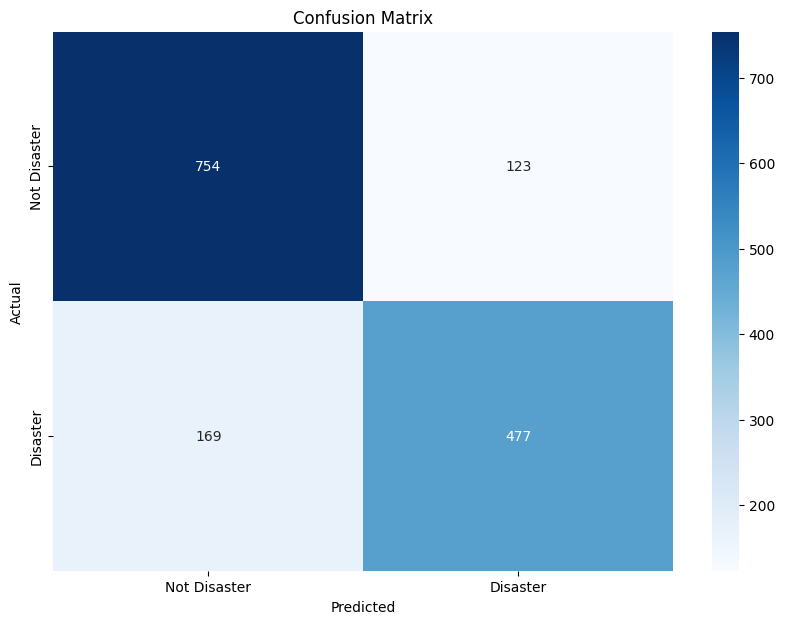

              precision    recall  f1-score   support

Not Disaster       0.82      0.86      0.84       877
    Disaster       0.80      0.74      0.77       646

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



In [30]:
val_predictions = model.predict(val_dataset)
val_predictions = (val_predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(y_val, val_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Disaster', 'Disaster'], yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_val, val_predictions, target_names=['Not Disaster', 'Disaster']))

## DistilBert
Another model that we can utilize is DistilBert which is a smaller and lighter version of the BERT model. It retains 97% of BERT's language understanding capabilities while being 60% faster and using 40% less memory. We will implement this model to compare with the above model created with the aid of Google's word embedding model.

We will implement a similar model to the previous where we use A Dense layer with relu as the activation function and Dropout set to 0.5. There will be a final Dense layer with sigmoid activation at the end. Additionally, we will implement Early stopping and test Learing rate scheduling vs Learning rate decrease on plateau.

In [31]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts.to_list(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf')

train_features = tokenize_texts(X_train, tokenizer)
val_features = tokenize_texts(X_val, tokenizer)

y_train = np.array(y_train)
y_val = np.array(y_val)

C:\Users\Ryan\anaconda3\envs\tf-gpu\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [32]:
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

input_ids = tf.keras.Input(shape=(128,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(128,), dtype=tf.int32, name="attention_mask")

bert_output = bert_model(input_ids, attention_mask=attention_mask)
sequence_output = bert_output.last_hidden_state
cls_token = sequence_output[:, 0, :]

dense = Dense(32, activation='relu', kernel_regularizer= l2(0.02))(cls_token)
dropout = Dropout(0.5)(dense)
output = Dense(1, activation='sigmoid')(dropout)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 128, 768),                                                   
                                 hidden_states=None                                           

In [33]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

def exponential_decay(epoch, lr = initial_lr):
    initial_lr = lr
    k = 0.1
    return initial_lr * tf.math.exp(-k * epoch)

lr_scheduler = LearningRateScheduler(exponential_decay)

history = model.fit(
    {'input_ids': train_features['input_ids'], 'attention_mask': train_features['attention_mask']},
    y_train,
    validation_data=({'input_ids': val_features['input_ids'], 'attention_mask': val_features['attention_mask']}, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
191/191 [==============================] - 40s 177ms/step - loss: 1.5074 - accuracy: 0.7473 - val_loss: 1.3316 - val_accuracy: 0.7636 - lr: 1.0000e-04
Epoch 2/10
191/191 [==============================] - 32s 170ms/step - loss: 0.9847 - accuracy: 0.8361 - val_loss: 0.8832 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 3/10
191/191 [==============================] - 32s 167ms/step - loss: 0.6590 - accuracy: 0.8718 - val_loss: 0.6757 - val_accuracy: 0.8076 - lr: 1.0000e-04
Epoch 4/10
191/191 [==============================] - 32s 166ms/step - loss: 0.4353 - accuracy: 0.9094 - val_loss: 0.6101 - val_accuracy: 0.8037 - lr: 1.0000e-04
Epoch 5/10
191/191 [==============================] - 32s 166ms/step - loss: 0.2799 - accuracy: 0.9394 - val_loss: 0.8185 - val_accuracy: 0.7820 - lr: 1.0000e-04
Epoch 6/10
191/191 [==============================] - 30s 156ms/step - loss: 0.1967 - accuracy: 0.9594 - val_loss: 0.7885 - val_accuracy: 0.7905 - lr: 1.0000e-04
Epoch 7/10
191/191 [========

In [34]:
loss, accuracy = model.evaluate({'input_ids': val_features['input_ids'], 'attention_mask': val_features['attention_mask']}, y_val)
print(f'Validation Accuracy: {accuracy:.4f}')

48/48 [==============================] - 2s 43ms/step - loss: 0.6101 - accuracy: 0.8037
Validation Accuracy: 0.8037


#### Evaluation

Overall, this method performs similar to the optimized method above having similar F1 Scores as well as similar accuracy.

48/48 [==============================] - 3s 40ms/step


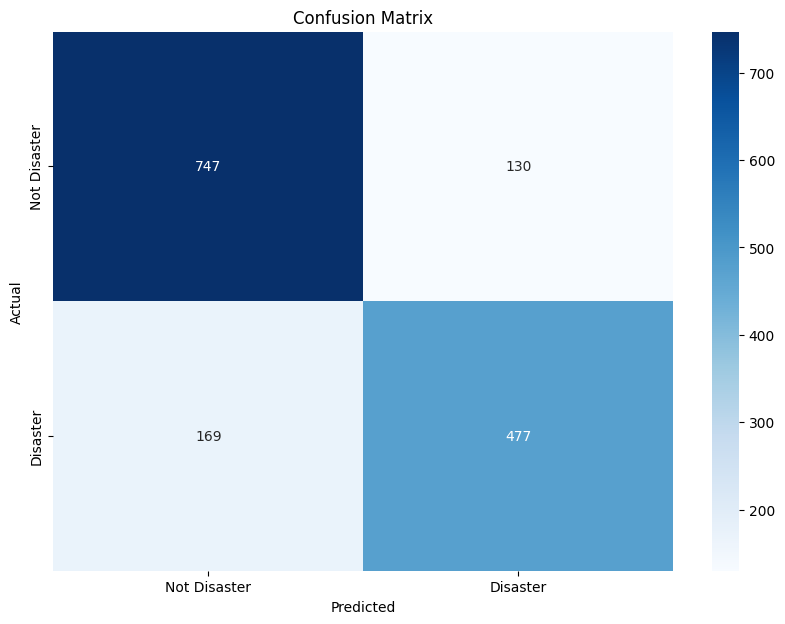

              precision    recall  f1-score   support

Not Disaster       0.82      0.85      0.83       877
    Disaster       0.79      0.74      0.76       646

    accuracy                           0.80      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.80      0.80      0.80      1523



In [35]:
val_predictions = model.predict({'input_ids': val_features['input_ids'], 'attention_mask': val_features['attention_mask']})
val_predictions = (val_predictions > 0.5).astype(int).flatten()

conf_matrix = confusion_matrix(y_val, val_predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Disaster', 'Disaster'], yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_val, val_predictions, target_names=['Not Disaster', 'Disaster']))

## Submission Output

Here we will calculate the predictions for the test dataset of the disaster tweets and create a dataframe for submission. On data loading, we will process the data using the same clean function and then tokenize the text using the DistillBert embeddings. Finally we will predict the final targets and output thse to the submission file.

In [36]:
test_data = pd.read_csv(os.path.join(r'C:\Users\Ryan\Files\DTSA 5511\NLP Project', 'test.csv'))
print("Test Data")
test_data['cleaned_text'] = test_data['text'].apply(clean_text)
display(test_data.head())

Test Data


,id,keyword,location,text,cleaned_text
0,0,NaN,NaN,Just happened a terrible car crash,happen terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.",hear earthquake different city stay safe everyone
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",forest fire spot pond geese flee across street save
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse light spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan


In [37]:
test_features = tokenize_texts(test_data['cleaned_text'], tokenizer)
predictions = model.predict({'input_ids': test_features['input_ids'], 'attention_mask': test_features['attention_mask']})
predictions = (predictions > 0.5).astype(int).flatten()

submission = pd.DataFrame({
    'id': test_data['id'],
    'target': predictions
})
submission.to_csv('submission.csv', index=False)

102/102 [==============================] - 4s 40ms/step


## Conclusion

We started off this project with an analysis of the disaster tweet dataset. We started with an analysis of keywords and then went into text cleaning of the text field. We cleaned out unnecessary words and created a cleaned text column that could be effectively used for modeling. 

We then proceeded to modeling by utilizing Google's endim50 model and the DistilBERT model for word embeddings. These were utilized in a Sequential model that outputted a classification. All of the models performed around 80% accuracy and F1 score indicating reasonable performance. 

While this model performed reasonably. Further improvements could be made by looking more into the text cleaning. There were some words that did not necessarily aid in the classification still in the dataset. The dataset is also imbalanced with more No Disaster data then Disaster data. If we oversampled the data and balanced the data we could create a more balanced model. This may also benefit from Cross Validation to help generalize the model. I also think looking into other models like pytorch and further focus on tuning would aid in improving the model's performance.